In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
df_ = pd.read_csv('Telco-Customer-Churn_2.csv')
df = df_.copy()

Hedef değişkenimiz atanması ve bozuk olan bir stünun tekrardan tanımlanması:

In [2]:
TARGET = 'Churn'
df['TotalCharges'] = df['tenure']*df['MonthlyCharges']

Data Frame'in bir özetine bakılması:

In [3]:
def check_df(dataframe, head = 5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### nunique #####################")
    print(dataframe.nunique())
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object
##################### NA #####################
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        

Kategorik, numerik ve kategorik fakat cardinal olan değişkenlerin saptanması:

In [4]:
def grab_col_names(dataframe, target, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri
        target: str
                Bağımlı(hedef) değişken

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols_mask = [col for col in dataframe.columns if dataframe[col].dtypes == "O"
                     and dataframe[col].nunique() < car_th and col != target]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != "O"
                   and dataframe[col].nunique() < cat_th and col != target]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == "O" and
                   col not in cat_cols_mask and col != target]

    cat_cols = cat_cols_mask + num_but_cat

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"
                and col not in num_but_cat and col != target]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df, TARGET)

Observations: 7043
Variables: 21
cat_cols: 16
num_cols: 3
cat_but_car: 1
num_but_cat: 1


Kategorik değişkenlerin özetlerine bakma:

        gender     Ratio
Male      3555  50.47565
Female    3488  49.52435
##########################################


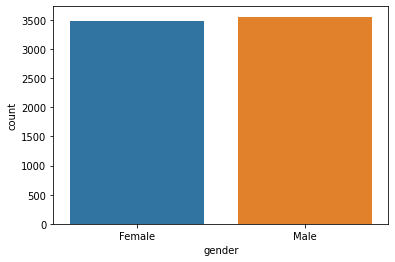

     Partner     Ratio
No      3641  51.69672
Yes     3402  48.30328
##########################################


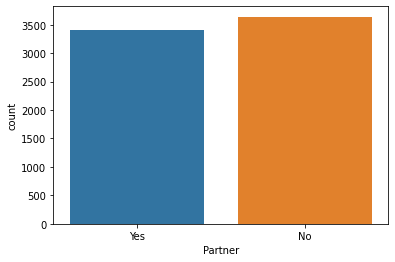

     Dependents      Ratio
No         4933  70.041176
Yes        2110  29.958824
##########################################


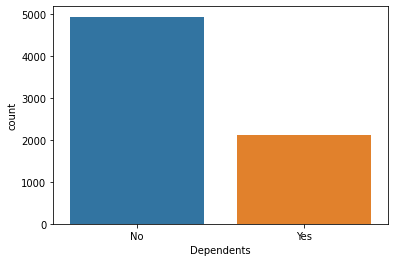

     PhoneService      Ratio
Yes          6361  90.316626
No            682   9.683374
##########################################


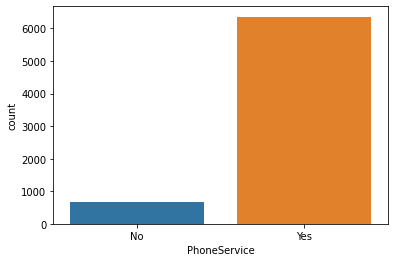

                  MultipleLines      Ratio
No                         3390  48.132898
Yes                        2971  42.183729
No phone service            682   9.683374
##########################################


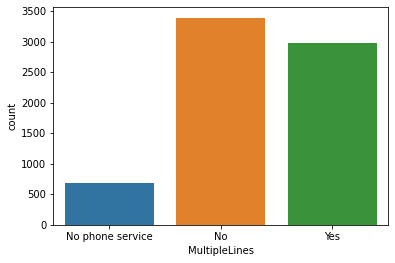

             InternetService      Ratio
Fiber optic             3096  43.958540
DSL                     2421  34.374556
No                      1526  21.666903
##########################################


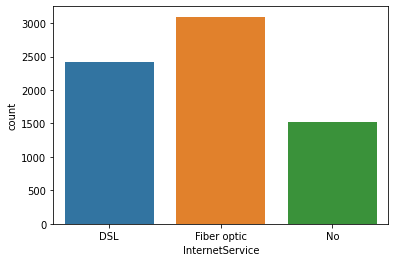

                     OnlineSecurity      Ratio
No                             3498  49.666335
Yes                            2019  28.666761
No internet service            1526  21.666903
##########################################


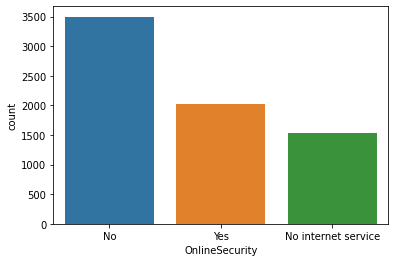

                     OnlineBackup      Ratio
No                           3088  43.844952
Yes                          2429  34.488144
No internet service          1526  21.666903
##########################################


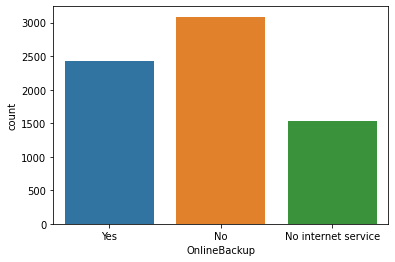

                     DeviceProtection      Ratio
No                               3095  43.944342
Yes                              2422  34.388755
No internet service              1526  21.666903
##########################################


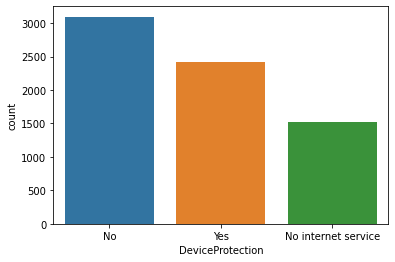

                     TechSupport      Ratio
No                          3473  49.311373
Yes                         2044  29.021724
No internet service         1526  21.666903
##########################################


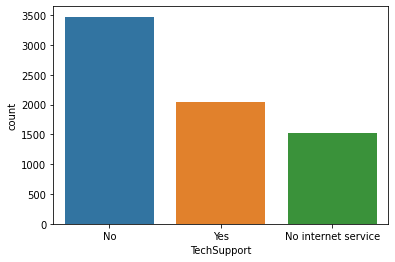

                     StreamingTV      Ratio
No                          2810  39.897771
Yes                         2707  38.435326
No internet service         1526  21.666903
##########################################


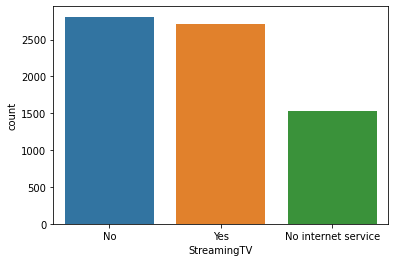

                     StreamingMovies      Ratio
No                              2785  39.542808
Yes                             2732  38.790288
No internet service             1526  21.666903
##########################################


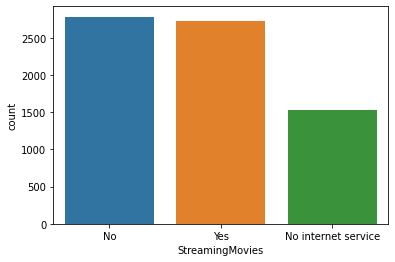

                Contract      Ratio
Month-to-month      3875  55.019168
Two year            1695  24.066449
One year            1473  20.914383
##########################################


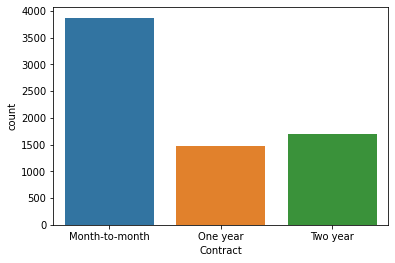

     PaperlessBilling      Ratio
Yes              4171  59.221922
No               2872  40.778078
##########################################


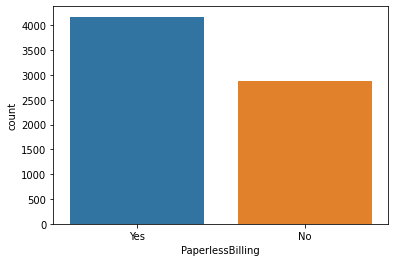

                           PaymentMethod      Ratio
Electronic check                    2365  33.579441
Mailed check                        1612  22.887974
Bank transfer (automatic)           1544  21.922476
Credit card (automatic)             1522  21.610109
##########################################


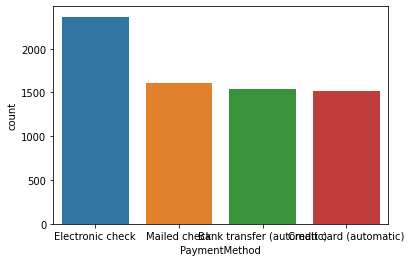

   SeniorCitizen      Ratio
0           5901  83.785319
1           1142  16.214681
##########################################


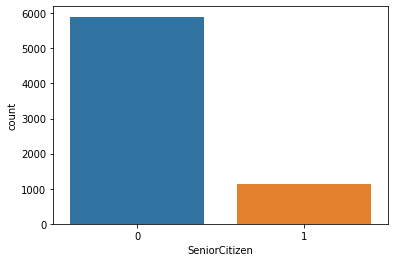

In [5]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

Numerik değişkenlerin dağılımına bakma:

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: tenure, dtype: float64


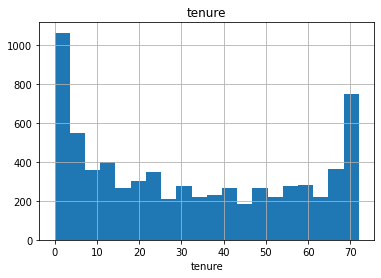

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MonthlyCharges, dtype: float64


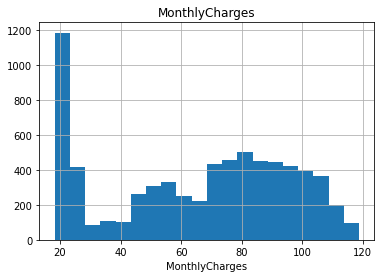

count    7043.000000
mean     2279.581350
std      2264.729447
min         0.000000
5%         48.600000
10%        82.920000
20%       265.460000
30%       548.280000
40%       949.360000
50%      1393.600000
60%      2062.000000
70%      3125.760000
80%      4463.040000
90%      5978.840000
95%      6919.995000
99%      8038.800000
max      8550.000000
Name: TotalCharges, dtype: float64


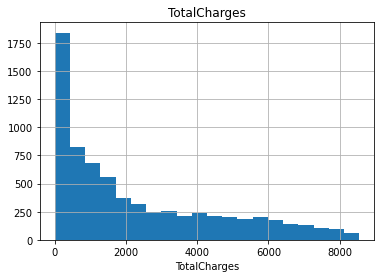

In [6]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

Numerik değişkenlerde aykırı değerlerin yakalanması:

In [7]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name, print_values=False):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) |
                 (dataframe[col_name] < low_limit)].any(axis=None):
        if print_values:
            print(f'Values with higher values than upper limit in {col_name}:\n'
                  f'{dataframe.loc[dataframe[col_name] > up_limit, col_name]}\n')
            print(f'Values with lower values than lower limit in {col_name}:\n'
                  f'{dataframe.loc[dataframe[col_name] < low_limit, col_name]}\n',)
        else:
            print(f'There is outlined data in {col_name}\n')
        return True
    else:
        print(f'There is no outlined data in {col_name}\n')
        return False

for col in df[num_cols].columns:
    check_outlier(df, col, print_values=True)

There is no outlined data in tenure

There is no outlined data in MonthlyCharges

There is no outlined data in TotalCharges



Eksik değerlerin yakalanması:

In [8]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

Eksik değer veya aykırı bir değer bulunmadığı için veriler üzerindeki ön işleme burada bitmiştir fakat: 
1. Aykırı değerler saptansaydı 2 farklı seçeneğmiz olurdu:
- Aykırı değerler çeyreklik değerlere bastırılabilirdi.
- Aykırı değere sahip gözlemlerin direkt olarak dataframe'den atılması tercih edilebilirdi.
2. Eksik değerler yakalansaydı 3 farklı seçeneğinimiz olurdu:
- Eksik değere sahip olan gözlemler direkt olarak gözlemden silinirdi.
- Eksik değerlere içerisinde bulunduğu değişkenin(sütunun) medyan değeri ya da mod değeri atanabilirdi.
- K-en yakın komşu gibi bir modelleme ile eksik değere sahip olan gözleme yakın olanlar saptanırdı ve bu eksik değere benzer gözlemlerdeki değerler atanabilirdi.


Feature Engineering (Özellik mühendisliği)

In [9]:
df.loc[(df['Partner'] == 'No') & (df['Dependents'] == 'No'), 'NEW_IS_ALONE'] = 'Yes'
df.loc[(df['Partner'] == 'Yes') | (df['Dependents'] == 'Yes'), 'NEW_IS_ALONE'] = 'No'

df.loc[(df['OnlineSecurity'] == 'Yes') & (df['OnlineBackup'] == 'Yes') &
       (df['DeviceProtection'] == 'Yes'), 'NEW_IS_CAUTIOUS'] = 'Yes'
df.loc[(df['OnlineSecurity'] != 'Yes') | (df['OnlineBackup'] != 'Yes') |
       (df['DeviceProtection'] != 'Yes'), 'NEW_IS_CAUTIOUS'] = 'No'

df.loc[(df['SeniorCitizen'] == 1) & (df['TechSupport'] == 'Yes'), 'NEW_IS_HELPLESS'] = 'Yes'
df.loc[(df['SeniorCitizen'] == 0) | (df['TechSupport'] != 'Yes'), 'NEW_IS_HELPLESS'] = 'No'

df['tenure_MonthlyCharges_Ratio'] = df['tenure'] / df['MonthlyCharges']

Binary türündeki kategorik değişkenlerin encode'lanması:

In [10]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

for col in binary_cols:
    label_encoder(df, col)

Binary türünde olmayan kategorik değişkenlerin one-hot encoder'dan geçirilmesi:

In [11]:
for col in cat_cols:
    if col not in binary_cols:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

Encoding işlemleri sonrası kategorik değişkenlerin tekrardan yakalanması:

In [12]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, TARGET)

Observations: 7043
Variables: 36
cat_cols: 30
num_cols: 4
cat_but_car: 1
num_but_cat: 30


Numerik değişkenlerin Scale edilmesi:

In [13]:
mms = MinMaxScaler()
df[num_cols] = mms.fit_transform(df[num_cols])

Datasetine uygun en iyi modelin seçilmesi:

In [14]:
def check_test_scores(results):
    print(f'test accuracy score: {results["test_accuracy"].mean()}')
    print(f'test roc_auc score: {results["test_roc_auc"].mean()}')
    print(f'test recall score: {results["test_recall"].mean()}')
    print(f'test precision score: {results["test_precision"].mean()}')
    print(f'test f1 Score: {results["test_f1"].mean()}')

y = df[TARGET]
X = df.drop([TARGET, 'customerID'], axis=1)

for alg in [RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, LGBMClassifier, CatBoostClassifier, LogisticRegression]:

    model = alg(random_state=33)
    if alg == CatBoostClassifier:
        model = alg(random_state=33, verbose=False)
    cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'f1',
                                                                'precision', 'recall', 'roc_auc'])
    print(f'-----------Scores of {alg}-----------')
    check_test_scores(cv_results)

-----------Scores of <class 'sklearn.ensemble._forest.RandomForestClassifier'>-----------
test accuracy score: 0.7887283050519388
test roc_auc score: 0.823613306056175
test recall score: 0.47297816518759594
test precision score: 0.638282841654964
test f1 Score: 0.5431787323298354
-----------Scores of <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>-----------
test accuracy score: 0.8059067318859281
test roc_auc score: 0.8471317543522361
test recall score: 0.5259465814110192
test precision score: 0.6720572643884717
test f1 Score: 0.5899855266345833
-----------Scores of <class 'xgboost.sklearn.XGBClassifier'>-----------
test accuracy score: 0.7837590328408285
test roc_auc score: 0.8240108039379432
test recall score: 0.5093647402904619
test precision score: 0.6117973094997424
test f1 Score: 0.5557263657635524
-----------Scores of <class 'lightgbm.sklearn.LGBMClassifier'>-----------
test accuracy score: 0.7914228337312085
test roc_auc score: 0.8331078729608283
test recall score: 0

En iyi modeller: Logistic Regresyon, Gradient Boosting, Catboost, LGBM

Seçilmiş modeller üzerinden hiperparametr optimizasyonu yapmak:

In [16]:
# LGBM
lgbm_model = LGBMClassifier(random_state=33)
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results_lgbm = cross_validate(lgbm_final, X, y, cv=5, scoring=['accuracy', 'f1',
                                                                'precision', 'recall', 'roc_auc'])
print("LGBM done")

# CatBoost
catboost_model = CatBoostClassifier(random_state=33, verbose=False)
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=False).fit(X, y)

catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results_cat = cross_validate(catboost_final, X, y, cv=5, scoring=['accuracy', 'f1',
                                                                'precision', 'recall', 'roc_auc'])
print("CatBoost done")

# GradientBoosting
gbm_model = GradientBoostingClassifier(random_state=33)
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [100, 500],
              "subsample": [1, 0.7]}

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results_gbm = cross_validate(gbm_final, X, y, cv=5, scoring=['accuracy', 'f1',
                                                                'precision', 'recall', 'roc_auc'])
print("GBM done")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
LGBM done
CatBoost done
Fitting 5 folds for each of 16 candidates, totalling 80 fits
GBM done


Hiperparatmetre optimizasyonu yapılmış model skorları:

In [17]:
print('------LGBM------')
check_test_scores(cv_results_lgbm)
print('------CAT------')
check_test_scores(cv_results_cat)
print('------GBM------')
check_test_scores(cv_results_gbm)

------LGBM------
test accuracy score: 0.79937606861733
test roc_auc score: 0.8434685865917597
test recall score: 0.5109647173517226
test precision score: 0.6578986451421927
test f1 Score: 0.575002501589087
------CAT------
test accuracy score: 0.8067587021743339
test roc_auc score: 0.8488458920347117
test recall score: 0.5147137675445513
test precision score: 0.6799748840713349
test f1 Score: 0.585793385404401
------GBM------
test accuracy score: 0.8051965046132009
test roc_auc score: 0.8485546614897721
test recall score: 0.5131080557984832
test precision score: 0.6748243133752594
test f1 Score: 0.582924784911796
